<a href="https://colab.research.google.com/github/arizonaCameraLab/computationalImaging/blob/master/Chapter10SamplingStrategy/InterferometricFocalPlanesMutualIntensityDistribution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Inteferometric Focal Plane Arrays
## David Brady
## University of Arizona
## December 2024


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import j1  # Bessel function of the first kind
from scipy.integrate import quad
from scipy.integrate import dblquad
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams.update({'font.size': 22})


## impulse response

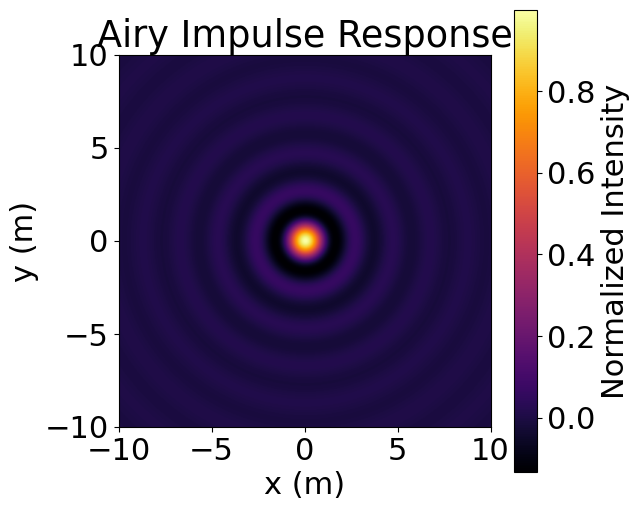

In [2]:
def airyPSF(r):
    """
    Calculate the Airy impulse response .

    Parameters:
        r (ndarray): Radial distances from the center lambda f/#.

    Returns:
        ndarray: The normalized impulse response.
    """

    # Avoid division by zero at the center
    response = np.zeros_like(r)
    non_zero = r != 0
    response[non_zero] = 2*j1(np.pi*r[non_zero]) / (np.pi*r[non_zero])
    response[~non_zero] = 1.0  # Central maximum (Airy disk peak)

    return response

# Visualization
x = np.linspace(-10, 10, 500)  # Spatial range (meters)
X, Y = np.meshgrid(x, x)
R = np.sqrt(X**2 + Y**2)  # Radial distance

response = airyPSF(R)

plt.figure(figsize=(6, 6))
plt.imshow(response, extent=[x.min(), x.max(), x.min(), x.max()], cmap='inferno')
plt.colorbar(label='Normalized Intensity')
plt.title('Airy Impulse Response')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.show()


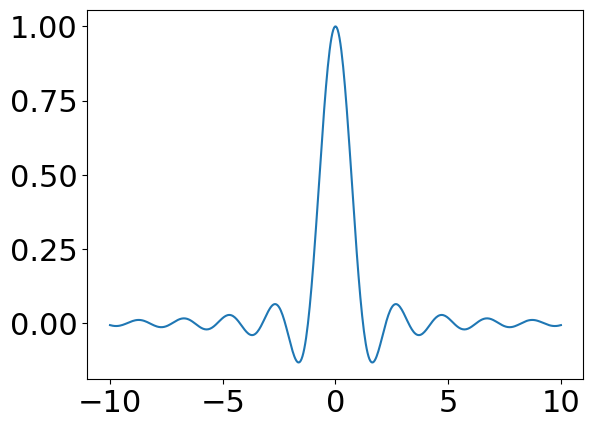

In [ ]:
plt.plot(x, airyPSF(x))

In [ ]:
def J(x1, y1, x2, y2, xo, yo):
  # mutual intensity due to a point source at xo, yo
  j= airyPSF(np.sqrt((x1-xo)**2+(y1-yo)**2))*airyPSF(np.sqrt((x2-xo)**2+(y2-yo)**2))
  return j

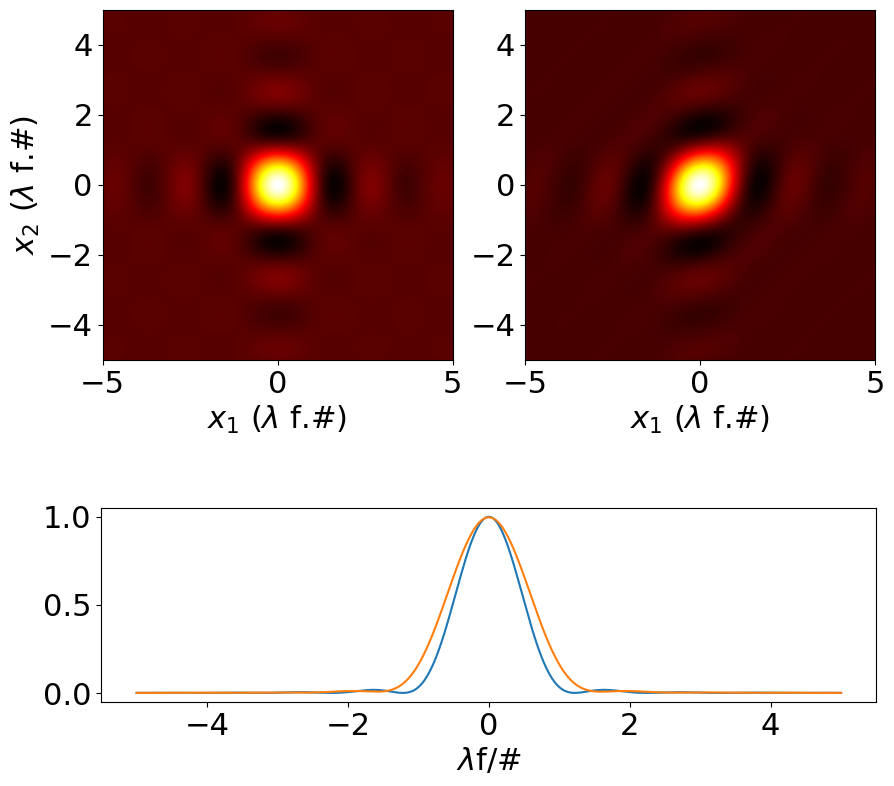

In [ ]:
# Visualization
x = np.linspace(-5, 5, 500)  # Spatial range (meters)
X, Y = np.meshgrid(x, x)

plt.figure(figsize=(10, 10))
plt.subplot(2,2,1)
plt.imshow(J(X,0,Y,0,0,0), extent=[x.min(), x.max(), x.min(), x.max()], cmap='hot')
plt.xlabel(r'$x_1$ ($\lambda$ f.#)')
plt.ylabel(r'$x_2$ ($\lambda$ f.#)')
plt.subplot(2,2,2)
plt.imshow((J(X,0,Y,0,.25,0)+J(X,0,Y,0,-.25,0)), extent=[x.min(), x.max(), x.min(), x.max()], cmap='hot', origin='lower')
plt.xlabel(r'$x_1$ ($\lambda$ f.#)')
ax= plt.subplot(2,1,2)
plt.plot(x,J(x,0,x,0,0,0))
plt.plot(x,(J(x,0,x,0,.3,0)+J(x,0,x,0,-.3,0))/1.6)
plt.xlabel(r"$\lambda$f/#")
ax.set_aspect(2.5)
plt.savefig("mutual_intensity.pdf")


## Estimation of mutual intensity for 2 mode systems

In [3]:


def generate_measurements(a, b, c, d, N, H_list):
    """
    Given a,b,c,d, total photon number N, and a list of measurement matrices H,
    generate Poisson measurements of the form diag(H J H^\dagger).

    We assume that Tr(J) = a+b and that the total number of photons N
    is allocated evenly among the given measurement settings.

    For each H, we send N_measure = N/len(H_list) photons.
    The expected counts at each detector is: counts = N_measure * G_ii
    where G = H J H^\dagger and G_ii are its diagonal elements normalized so that sum(G_ii) = a+b.
    Actually, G_ii = (H J H^\dagger)_{ii}, and sum of diagonal = a+b.
    """

    J = np.array([[a, c+1j*d],
                  [c-1j*d, b]], dtype=complex)

    # Number of photons per measurement configuration
    N_measure = N/len(H_list)

    measurements = []
    for H in H_list:
        G = H @ J @ H.conjugate().T
        # G should be a 2x2 matrix
        # Expected counts on each detector:
        # The total intensity is a+b, so absolute counts:
        exp_counts_1 = N_measure * (G[0,0].real)   # G[0,0] real
        exp_counts_2 = N_measure * (G[1,1].real)   # G[1,1] real
        # Add Poisson noise
        meas_1 = np.random.poisson(exp_counts_1)
        meas_2 = np.random.poisson(exp_counts_2)
        measurements.append((meas_1, meas_2))
    return measurements

def construct_linear_system(H_list):
    """
    Construct the linear system M x = y that relates [a,b,c,d] to the measured intensities.
    For each H_i and each detector output, we have:
       G = H_i J H_i^\dagger, and we consider G_11 and G_22.
    G_ii is linear in a,b,c,d:
       G_ii = sum_{p,q} H_i[p]*J[p,q]*H_i[q]^*
            = a * coeff_a_ii + b * coeff_b_ii + c * coeff_c_ii + d * coeff_d_ii

    We'll return a function that, given (a,b,c,d), returns the vector G_ii,
    and also a matrix of coefficients that we can use to solve for (a,b,c,d)
    once we have measurements.
    """

    # We'll find the coefficients by symbolic expansion with a generic J and each H.
    # J = [[a, c+id], [c-id, b]]
    # G_ii = (H J H^\dagger)_{ii}
    # Expand linearity:
    # Let’s define the helper to get coefficients:
    def get_coefficients(H):
        # Coeff for a: put J = [[1,0],[0,0]] and compute (H J H^\dagger)
        J_a = np.array([[1,0],[0,0]], dtype=complex)
        G_a = H @ J_a @ H.conjugate().T

        # Coeff for b: J_b = [[0,0],[0,1]]
        J_b = np.array([[0,0],[0,1]], dtype=complex)
        G_b = H @ J_b @ H.conjugate().T

        # Coeff for c: J_c = [[0,1],[1,0]] real part
        # Actually for c we must consider c*(1) and d*(i):
        # For c: set d=0 and c=1: J_c = [[0,1],[1,0]]
        J_c = np.array([[0,1],[1,0]], dtype=complex)
        G_c = H @ J_c @ H.conjugate().T

        # For d: set c=0 and d=1: J_d = [[0,i],[-i,0]]
        J_d = np.array([[0,1j],[-1j,0]], dtype=complex)
        G_d = H @ J_d @ H.conjugate().T

        # Return coefficients for the two diagonal elements as tuples
        # G_11 = a*G_a[0,0] + b*G_b[0,0] + c*G_c[0,0] + d*G_d[0,0]
        # G_22 similarly
        coeff_11 = [G_a[0,0].real, G_b[0,0].real, G_c[0,0].real, G_d[0,0].real]
        coeff_22 = [G_a[1,1].real, G_b[1,1].real, G_c[1,1].real, G_d[1,1].real]
        return coeff_11, coeff_22

    M = []
    for H in H_list:
        c11, c22 = get_coefficients(H)
        M.append(c11) # For G_11
        M.append(c22) # For G_22

    M = np.array(M) # 6x4 matrix (since we have H1,H2,H3 => 6 equations)
    return M

def estimate_abcd(measurements, M, N):
    """
    Given measurements and coefficient matrix M, solve for (a,b,c,d).

    measurements: list of tuples (meas_1, meas_2) from each H configuration
    M: coefficient matrix 6x4
    N: total photons used for these measurements

    Each measurement corresponds to:
      meas_1 ≈ Poisson(N_i * G_11) and meas_2 ≈ Poisson(N_i * G_22)
    where N_i = N/len(H_list).

    After obtaining meas_1, meas_2, we must convert them back to estimates of G_ii:
      G_11_est = meas_1 / N_i
      G_22_est = meas_2 / N_i

    Then we solve M x = y, where y is [G_11(H1), G_22(H1), G_11(H2), G_22(H2), G_11(H3), G_22(H3)].
    """

    # Number of measurement configurations:
    nH = len(measurements)
    N_i = N / nH

    y = []
    for (m1, m2) in measurements:
        y.append(m1/N_i)
        y.append(m2/N_i)
    y = np.array(y)

    # Solve for x = [a,b,c,d] using least squares
    x, residuals, rank, s = np.linalg.lstsq(M, y, rcond=None)
    a_est, b_est, c_est, d_est = x
    return a_est, b_est, c_est, d_est

def diagonalize_J(a, b, c, d):
    J = np.array([[a, c+1j*d],
                  [c-1j*d, b]], dtype=complex)
    eigvals, eigvecs = np.linalg.eigh(J)
    #D = eigvecs
    #J' = D^\dagger J D is diagonal
    return eigvals, eigvecs

def run_estimation(a_true, b_true, c_true, d_true, N_total):
    """
    Run the entire procedure:
    1. Define H1,H2,H3
    2. Use half the photons to measure and estimate (a,b,c,d)
    3. Diagonalize J to get D
    4. With the remaining photons, measure again (possibly in transformed basis)
    5. Re-estimate (a,b,c,d)
    """

    # Define measurement matrices H1,H2,H3
    H1 = (1/np.sqrt(3))*np.array([[1,0],[0,1]], dtype=complex)
    H2 = (1/np.sqrt(6))*np.array([[1,1],[1,-1]], dtype=complex)
    H3 = (1/np.sqrt(6))*np.array([[1,1j],[-1j,1]], dtype=complex)
    H_list = [H1, H2, H3]

    # First round: use N_total/2 photons
    N_first = N_total/4
    # Generate measurements
    measurements_1 = generate_measurements(a_true, b_true, c_true, d_true, N_first, H_list)

    # Construct linear system M
    M = construct_linear_system(H_list)

    # Estimate a,b,c,d from first measurements
    a_est1, b_est1, c_est1, d_est1 = estimate_abcd(measurements_1, M, N_first)
    print("First estimate:", a_est1, b_est1, c_est1, d_est1)

    # Diagonalize J from first estimate
    eigvals, D = diagonalize_J(a_est1, b_est1, c_est1, d_est1)

    # Second round: use remaining photons
    N_second = 3*N_total/4

    # Optionally, transform H by D to measure in the eigenbasis of J
    # H'_i = H_i * D (if we want to measure J' directly)
    # For simplicity, let's show how you'd do that:
    H_list_transformed = [H @ D for H in H_list]

    # Generate second measurements from true J but measured with transformed bases:
    # Note: If you prefer to measure again with the original H, just set H_list_transformed = H_list
    measurements_2 = generate_measurements(a_true, b_true, c_true, d_true, N_second, H_list_transformed)

    # Now we must construct M for the transformed H, because the relationship changes
    M_transformed = construct_linear_system(H_list_transformed)

    # Estimate again
    a_est2, b_est2, c_est2, d_est2 = estimate_abcd(measurements_2, M_transformed, N_second)
    print("Second estimate:", a_est2, b_est2, c_est2, d_est2)

    return (a_est1, b_est1, c_est1, d_est1), (a_est2, b_est2, c_est2, d_est2)


# Example usage:
if __name__ == "__main__":
    # True parameters
    a_true = 20
    b_true = 0.4
    c_true = 0.01
    d_true = -0.05
    N_total = 1e4 # total photons

    (a_est1, b_est1, c_est1, d_est1), (a_est2, b_est2, c_est2, d_est2) = run_estimation(a_true, b_true, c_true, d_true, N_total)
    print("True values:", a_true, b_true, c_true, d_true)
    print("Final estimates:", a_est2, b_est2, c_est2, d_est2)


First estimate: 19.703699999999994 0.5300999999999981 0.13859999999999997 0.22409999999999808
Second estimate: 20.316711888182006 0.286088111818004 0.21586886981128256 -0.15408300842957182
True values: 20 0.4 0.01 -0.05
Final estimates: 20.316711888182006 0.286088111818004 0.21586886981128256 -0.15408300842957182


In [ ]:
if __name__ == "__main__":
    # True parameters
    a_true = 1
    b_true = 1
    c_true = 0.1
    d_true = .1
    N_total = 1E3 # total photons

    (a_est1, b_est1, c_est1, d_est1), (a_est2, b_est2, c_est2, d_est2) = run_estimation(a_true, b_true, c_true, d_true, N_total)
    print("True values:", a_true, b_true, c_true, d_true)
    print("Final estimates:", a_est2, b_est2, c_est2, d_est2)

First estimate: 1.296 0.648 0.07200000000000001 0.19799999999999984
Second estimate: 1.2365078250036705 1.0014921749963297 0.23574018878916747 -0.04408485513818508
True values: 1 1 0.1 0.1
Final estimates: 1.2365078250036705 1.0014921749963297 0.23574018878916747 -0.04408485513818508


## measurement of harmonic functions

For impulse response $h(x)=\rm{sinc} (x)$, the object distribution $f(x)=1 + cos (2\pi ux)$ for $|u|\leq 1$ creates the mutual intensity

$$
g(x_1,x_2) \;=\; \rm{sinc}(x_2 - x_1) \;+\; (1 - |u|)\rm{sinc}\bigl((x_2 - x_1)(1 - |u|)\bigr)\,\cos\!\biggl(2\pi u\,\frac{x_1 + x_2}{2}\biggr)
$$


In [4]:
def j(x1, x2, u):
    return np.sinc(x2 - x1) + (1 - abs(u)) * np.sinc((x2 - x1) * (1 - abs(u)))*np.cos(2*np.pi*u*(x1 + x2)/2)



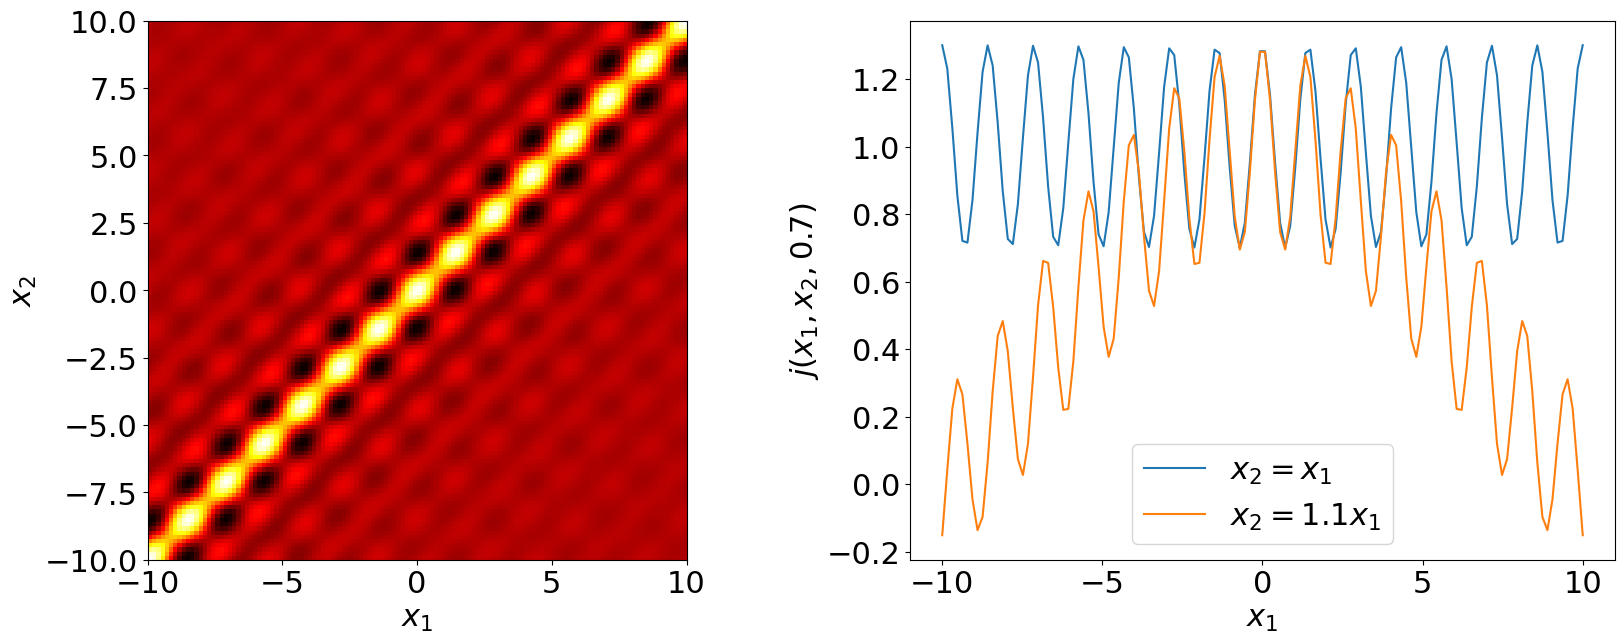

In [13]:
plt.figure(figsize=(20,7) )
xa=np.linspace(-10,10,128)
x, y = np.meshgrid(xa, xa)
plt.subplot(1,2,1)
plt.imshow(j(x,y,.7), extent=[x.min(), x.max(), x.min(), x.max()], cmap='hot', origin='lower')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.subplot(1,2,2)
xb =  xa # x2 = x1
plt.plot(xa, j(xa, xb, 0.7), label=r'$x_2 = x_1$')

xb = 1.1 * xa # x2 = 1.1*x1
plt.plot(xa, j(xa, xb, 0.7), label=r'$x_2 = 1.1x_1$')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$j(x_1, x_2, 0.7)$')
plt.legend()
plt.savefig('jHarmonic.pdf',  bbox_inches='tight')


In [ ]:
def sampleM(a, b, u):
    """
    Calculates the double integral of j(x1, x2, u) over the specified region.

    Args:
        a: The center of the integration region in the x1 direction.
        b: The center of the integration region in the x2 direction.
        u: Parameter for the function j.

    Returns:
        The result of the double integral.
    """
    def integrand(x1, x2):
        return j(x1, x2, u)

    result, error = dblquad(integrand, a - 0.25, a + 0.25, lambda x1: b - 0.25, lambda x1: b + 0.25)
    return result
def sampleJ(n,u):
  return [[sampleM(n,n,u), sampleM(n,n+.5,u)], [sampleM(n+.5,n,u), sampleM(n+.5,n+.5,u)]]
def sampleI(n, u):
  def integrand1(x ):
    return j(x, x, u)
  result, error = quad(integrand1, n - 0.25, n + 0.25)
  return result

The fringe visibility is  0.11788633826368293
The fringe visibility is  0.03340301505634108
The ratio is  3.5292124996753524


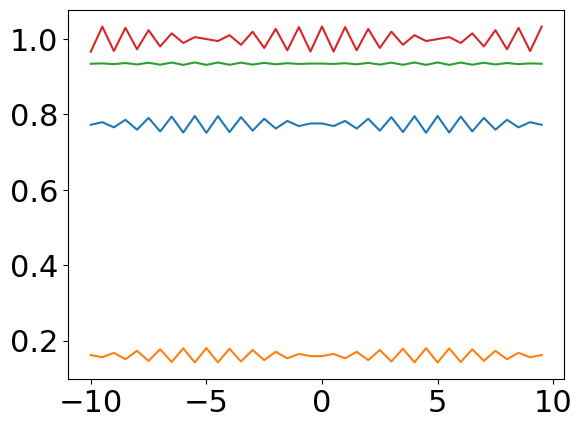

In [ ]:
# samples are multiplied by 2 to account for the pixel pitch \Delta x =0.5
x=np.arange(-10,10,.5)
vals =np.zeros((3,len(x)))
u=.95
for i in range(len(x)):
  J=sampleJ(x[i], u)
  up,s,vh=np.linalg.svd(J)
  vals[0,i]=s[0]
  vals[1,i]=s[1]
  vals[2,i]=sampleI(x[i],u)
plt.plot(x,2*vals[0,:])
plt.plot(x,2*vals[1,:])
plt.plot(x,2*(vals[0,:]+vals[1,:]))
plt.plot(x,2*vals[2,:])
plt.savefig('harmonicFringes.pdf')
print('The fringe visibility is ', (np.max(vals[1,:])-np.min(vals[1,:]))/(np.max(vals[1,:])+np.min(vals[1,:])))
print('The fringe visibility is ', (np.max(vals[2,:])-np.min(vals[2,:]))/(np.max(vals[2,:])+np.min(vals[2,:])))
print('The ratio is ', ((np.max(vals[1,:])-np.min(vals[1,:]))/(np.max(vals[1,:])+np.min(vals[1,:])))/((np.max(vals[2,:])-np.min(vals[2,:]))/(np.max(vals[2,:])+np.min(vals[2,:]))))


In [ ]:
2*np.min(vals[2,:])

0.966596984943659

## Sinc impulse response example


Assume that $\psi(x)={\rm sinc}(x)$, $\phi(x)={\rm sinc}(x-1)$.

In [ ]:
def j(x,delta):
  j=np.zeros((2,2))
  ps1=np.sinc(x-delta)
  ph1=np.sinc(x-delta-1)
  ps2=np.sinc(x+delta)
  ph2=np.sinc(x+delta-1)
  j[0,0]=ps1**2+ps2**2
  j[0,1]=ps1*ph1+ps2*ph2
  j[1,0]=ps1*ph1+ps2*ph2
  j[1,1]=ph1**2+ph2**2
  return j
def lam(x,delta):
  u, s,v=np.linalg.svd(j(x,delta))
  return s[1]
def lam0(x,delta):
  u, s,v=np.linalg.svd(j(x,delta))
  return s[0]
lamv=np.vectorize(lam)
lam0v=np.vectorize(lam0)

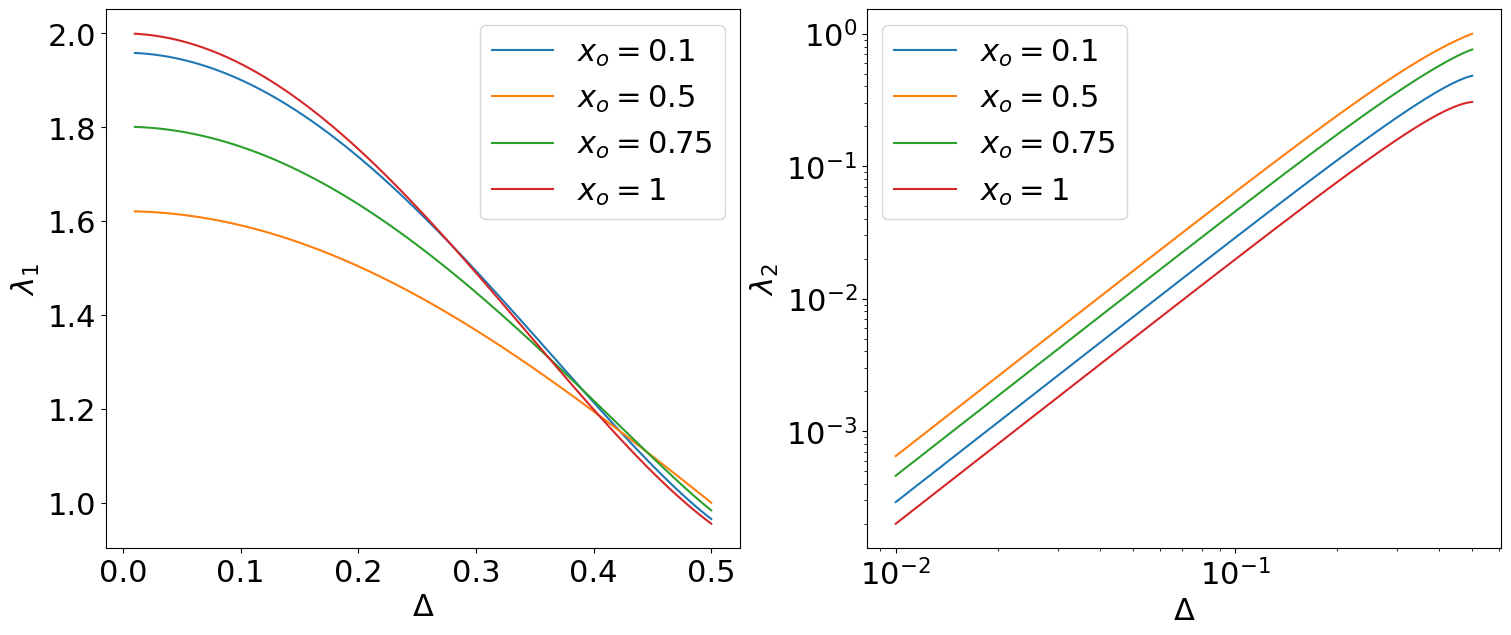

In [ ]:
plt.figure(figsize=(18,7))
delta=np.linspace(0.01,.5,100)
plt.subplot(1,2,2)
plt.loglog(delta,lamv(0.1,delta))
plt.loglog(delta,lamv(0.5,delta))
plt.loglog(delta,lamv(.75,delta))
plt.loglog(delta,lamv(1,delta))
plt.legend(['$x_o=0.1$','$x_o=0.5$','$x_o=0.75$','$x_o=1$'])
plt.xlabel(r'$\Delta$')
plt.ylabel(r'$\lambda_2$')
plt.subplot(1,2,1)
plt.plot(delta,lam0v(0.1,delta))
plt.plot(delta,lam0v(0.5,delta))
plt.plot(delta,lam0v(.75,delta))
plt.plot(delta,lam0v(1,delta))
plt.legend(['$x_o=0.1$','$x_o=0.5$','$x_o=0.75$','$x_o=1$'])
plt.xlabel(r'$\Delta$')
plt.ylabel(r'$\lambda_1$')
plt.savefig('sinc2Mode.pdf')

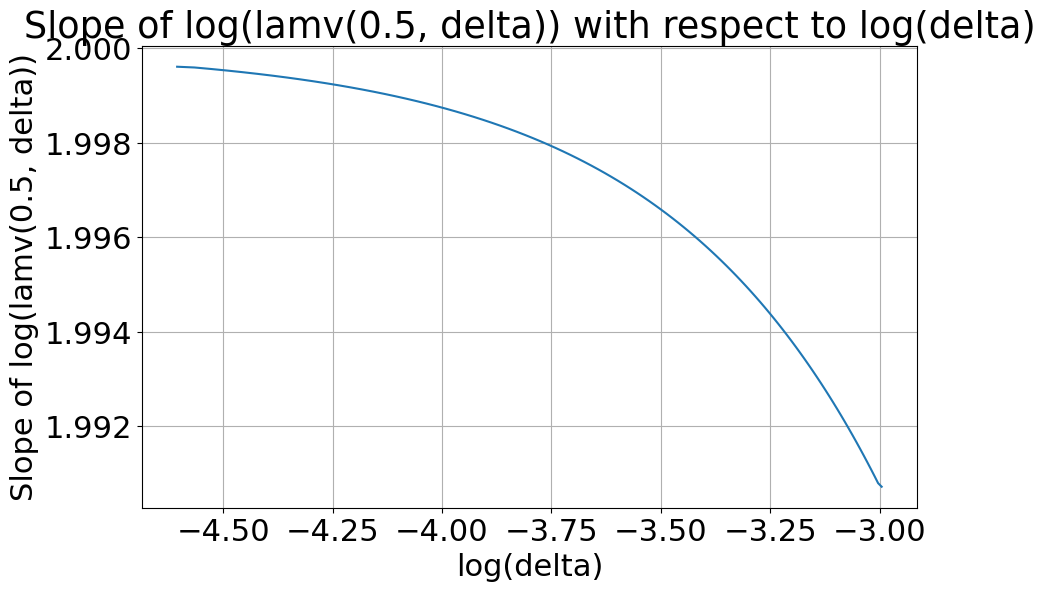

In [ ]:
# prompt: find the slope of log(lamv(.5,delta)) with respect to log(delta) over the range delta=.01 to .2

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from sklearn.decomposition import PCA
import cv2

# ... (rest of the provided code)

# Calculate the slope of log(lamv(0.5, delta)) with respect to log(delta)
delta = np.linspace(0.01, 0.05, 100)  # Use a finer grid for better accuracy
log_delta = np.log(delta)
log_lamv = np.log(lamv(0.5, delta))

# Use numpy's gradient function to calculate the slope efficiently
slope = np.gradient(log_lamv, log_delta)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(log_delta, slope)
plt.xlabel('log(delta)')
plt.ylabel('Slope of log(lamv(0.5, delta))')
plt.title('Slope of log(lamv(0.5, delta)) with respect to log(delta)')
plt.grid(True)
plt.show()

Text(0, 0.5, '$\\lambda_1$')

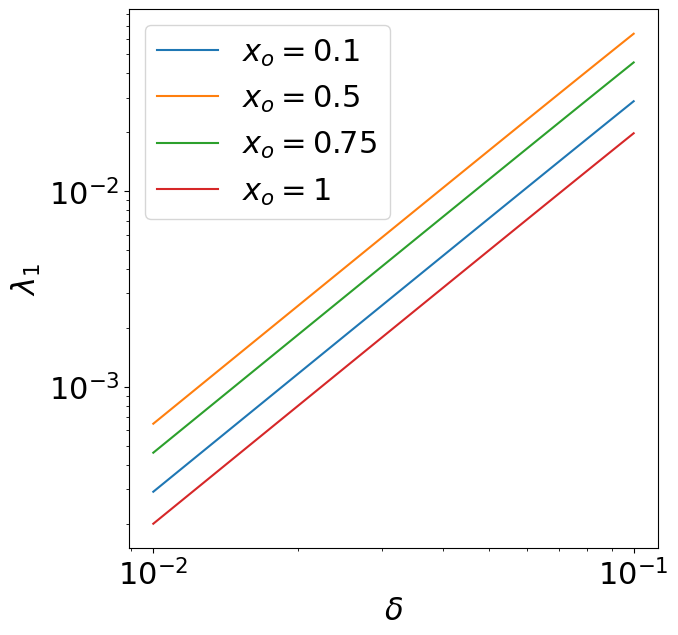

In [ ]:
plt.figure(figsize=(15,7))
delta=np.linspace(0.01,.1,100)
plt.subplot(1,2,1)
plt.loglog(delta,lamv(0.1,delta))
plt.loglog(delta,lamv(0.5,delta))
plt.loglog(delta,lamv(.75,delta))
plt.loglog(delta,lamv(1,delta))
plt.legend(['$x_o=0.1$','$x_o=0.5$','$x_o=0.75$','$x_o=1$'])
plt.xlabel(r'$\delta$')
plt.ylabel(r'$\lambda_1$')